# Data 607 &mdash; Winter 2023 &mdash; Assignment 1

**Submit a .ipynb file and a Colab link to the your solutions to the appropriate D2L dropbox by 23:59 on Wednesday, March 9. For the Colab link, make sure that the permission is set to "Anyone on the internet with this link can view".**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Exercise 1: It's nice to have lots of data!

We have observed that training accuracy is often a poor proxy for generalization accuracy. The purpose of this exercise is to demonstrate, in an example, that training accuracy and generalization accuracy are comparable if the training set is sufficiently large.

Here is a function to generate some synthetic classification data:

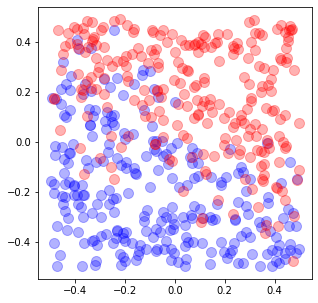

In [2]:
def make_data(size, s=0.15, theta=np.pi/3):
    u = np.array([np.cos(theta), np.sin(theta)])
    X = np.random.uniform(size=(size, 2)) - 0.5
    e = s*np.random.normal(size=size)
    y = 1*(X @ u + e > 0)
    return X, y

X, y = make_data(500)

plt.figure(figsize=(5,5))
ax = plt.gca()
ax.scatter(*X[y == 0].T, color=(0,0,1,0.3), s=100)
ax.scatter(*X[y == 1].T, color=(1,0,0,0.3), s=100)
ax.set_aspect(1)

Let's generate a big testing set for the purpose of estimating generalization  error:

In [3]:
X_te, y_te = make_data(100000)

For each $n$ between $100$ and $100000$ in increments of $100$, train a logistic regression model on a training set of size $n$ generated using `make_data`. Estimate the generalizaton accuracy of this model by the accuracy score on the test set constructed above. On the same axes, plot accuracies on the training set and on testing set versus $n$. Observe the behavior of the accuracy curves for large $n$.

Please label your plots!

### Solution to Exercise 1

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import plotly.express as px
import pandas as pd

result_df = pd.DataFrame(columns=['Size', 'Train_Accuracy', 'Test_Accuracy'])

for n in range(100, 100001, 100):
    X, y = make_data(n)
    log_reg = LogisticRegression()
    log_reg.fit(X, y)
    acc_train = accuracy_score(y, log_reg.predict(X))
    acc_test = accuracy_score(y_te, log_reg.predict(X_te))
    result_df.loc[len(result_df)] = [n, acc_train, acc_test]


fig = px.line(result_df,
              x = 'Size',
              y = ['Train_Accuracy', 'Test_Accuracy'],
              template = 'simple_white',
              color_discrete_sequence=['crimson', 'turquoise'],
              labels={"Size": "Train Size", 'value': 'Accuracy Score'},
              title = 'Comparing Train/Test Accuracy Scores with Respect to Train Size')
fig.show()

### Exercise 2: $k$-nearest neighbor regression

Consider a dataset

$$D=\{(x_1, y_1),\ldots,(x_n, y_n)\},$$

where $x_i\in\mathbb{R}^p$ and $y_i\in\mathbb{R}$.

For $x\in\mathbb{R}^p$, let $i_1(x),\ldots,i_n(x)$ be a permutation of the indices $1,\ldots,n$ such that

$$
\|x-x_{i_1(x)}\| \leq \|x-x_{i_2(x)}\| \leq \cdots \leq \|x-x_{i_n(x)}\|.
$$

In particular, $x_{i_1(x)},\ldots,x_{i_k(x)}$ are the $k$-nearest neighbors of $x$ among $x_1,\ldots,x_n$.

The $k$-nearest neighbor regressor $\hat{f}_D$ associated to $D$ is the function that assigns to $x\in \mathbb{R}^p$ the average of the $y$-values associated to the $k$ nearest neighbors of $x$ among $x_1,\ldots,x_n$:

$$
\hat{f}_D(x) = \frac1k \left( y_{i_1(x)} + \cdots + y_{i_k(x)}\right)
$$

In Scikit-Learn, nearest neighbor regressors are instances of the `KNeighborsRegressor` class, which can be imported from `sklearn.neighbors`. Like its classifier counterpart, `KNeighborsRegressor` takes a keyword argument `n_neighbors`, defaulting to `5`.

Here is some code to generate synthetic $1$-dimensional data for a regression problem. The data is distributed around the curve

$$
f(x) = \sqrt{x}\sin^2(2\pi x).
$$

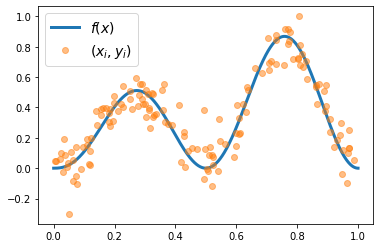

In [5]:
def f(x):
    return np.sqrt(x)*np.sin(2*np.pi*x)**2

def make_data(size, s=0.1, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    x = np.random.uniform(size=size)
    y = f(x) + s*np.random.normal(size=size)
    return x, y

x, y = make_data(150, random_state=42)
t = np.linspace(0, 1, 1000)
plt.plot(t, f(t), lw=3, label="$f(x)$")
plt.plot(x, y, "o", label="$(x_i, y_i)$", alpha=0.5)
plt.legend(loc="upper left", fontsize=14)
plt.show()

Split the dataset 80%/20% into a training set and a testing set.

Identify an optimal value for `n_neighbors` by randomly splitting training data 80%/20% into a training subset and a validation subset 200 times, imitating the procedure demonstrated in class for nearest neighbor classifiers. The optimal value for `n_neighbors` is the one that minimizes the average mean squared validation error, averaged over all 200 splittings.

Once you've identified an optimal value for `n_neighbors`, refit the model on the original training set and compute the mean squared error on the test set.

Plot the overlay a plot of your $k$-nearest neighbors regressor $\hat{f}_D$ on the curve $f(x)$.

### Solution to Exercise 2

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import plotly.express as px

x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1), y.reshape(-1,1), train_size=0.8, random_state=2023)

ks = list(range(1, 31, 2))
n_trials = 200
result_df = pd.DataFrame(columns=['k', 'MSE'])

for k in ks:
    model = KNeighborsRegressor(n_neighbors=k)
    mse = []
    for j in range(n_trials):
        x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=abs(j**2-32*j+1))
        model.fit(x_tr,y_tr)
        mse.append(mean_squared_error(y_val, model.predict(x_val)))
    result_df.loc[len(result_df)] = [k, np.mean(mse)]

In [7]:
best_k = int(result_df[result_df['MSE'] == min(result_df['MSE'])]['k'])
fig = px.line(result_df,
              x = 'k',
              y = 'MSE',
              template = 'simple_white',
              labels={'k': 'Number of Neighbors',
                      'MSE': 'MSE on Validation Set'},
              title = f'MSE on Validation Set Depending on Different "k" Values: Min. Val. MSE at k = {best_k}',
              color_discrete_sequence=['crimson'])
fig.add_vline(x = best_k, line_width=3, line_dash="dash", line_color="gray", name = 'Best K')
fig.add_annotation(x=best_k+4.5, 
                   y=np.max(result_df.MSE),
                   text=f'Min. Val. MSE = {min(result_df.MSE):.4f}, with k = {best_k}',
                   showarrow=False)
fig.data[0]['name'] = 'Validation MSE'
fig.data[0]['showlegend']=True
fig.show()

In [8]:
model = KNeighborsRegressor(n_neighbors=best_k)
model.fit(x_train, y_train)
mse_test = mean_squared_error(y_test, model.predict(x_test))
print(f'MSE in Test Data = {mse_test:.4f}, with k = {best_k}')

MSE in Test Data = 0.0114, with k = 7


In [9]:
function_df = pd.DataFrame()
function_df['Values'] = np.linspace(0, 1, 1000)
function_df['True Function'] = f(function_df['Values'])
function_df['KNN Function'] = model.predict(function_df[['Values']])

fig = px.line(function_df,
              x = function_df['Values'],
              y = ['True Function', 'KNN Function'],
              template = 'simple_white',
              color_discrete_sequence=['black', 'crimson'],
              labels={"Values": "x", 'value': 'y'},
              title = f'Comparing True Function with KNN Regression Function<br><sup>KNN fitted with k = {best_k} with Test MSE = {mse_test:.4f}</sup>')
fig.add_scatter(x = x,
                y = y,
                mode="markers",
                marker=dict(size=5, 
                            color="darkgray"),
                hoverinfo="skip",
                name="Observed Data")
fig.show()

### Exercise 3: Polynomial Regression

Repeat Exercise 2, but with polynomial regression (i.e., a pipeline composed of `PolynomialFeatures` and `LinearRegression`) in place of `KNeighborsRegressor` and the `degree` parameter of `PolynomialFeatures` instead of `n_neighbors`.

### Solution to Exercise 3

In [10]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1),
                                                    y.reshape(-1,1), 
                                                    train_size=0.8, 
                                                    random_state=2023)

degrees = list(range(1,21,1))
n_trials = 200
result_df = pd.DataFrame(columns=['Degree', 'MSE'])
for degree in degrees:
    x_poly_train= PolynomialFeatures(degree=degree, include_bias=False).fit_transform(x_train)
    mse = []
    for j in range(n_trials):
        x_poly_tr, x_poly_val, y_tr, y_val = train_test_split(x_poly_train, y_train, train_size=0.8, random_state=abs(j**2-32*j+1))
        polymodel = LinearRegression()
        polymodel.fit(x_poly_tr, y_tr)
        mse.append(mean_squared_error(y_val, polymodel.predict(x_poly_val)))
    result_df.loc[len(result_df)] = [degree, np.mean(mse)]

In [11]:
best_degree = int(result_df[result_df['MSE'] == min(result_df['MSE'])]['Degree'])
fig = px.line(result_df,
              x = 'Degree',
              y = 'MSE',
              template = 'simple_white',
              labels={'Degree': 'Polynomial Degree',
                      'MSE': 'MSE on Validation Set'},
              title = f'MSE on Validation Set Depending on Different "Degree" Values: Min. Val. MSE at Degree = {best_degree}',
              color_discrete_sequence=['crimson'])
fig.add_vline(x = best_degree, line_width=3, line_dash="dash", line_color="gray", name = 'Best Degree')
fig.add_annotation(x=best_k+4.5, 
                   y=np.max(result_df.MSE),
                   text=f'Min. Val. MSE = {min(result_df.MSE):.4f}, with Degree = {best_degree}',
                   showarrow=False)
fig.data[0]['name'] = 'Validation MSE'
fig.data[0]['showlegend']=True
fig.show()

In [12]:
model = LinearRegression()
x_poly_train = PolynomialFeatures(degree = best_degree, include_bias=False).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree = best_degree, include_bias=False).fit_transform(x_test)
model.fit(x_poly_train, y_train)
mse_test = mean_squared_error(y_test, model.predict(x_poly_test))
print(f'MSE in Test Data = {mse_test:.4f}, with k = {best_degree}')

MSE in Test Data = 0.0108, with k = 8


In [13]:
function_df = pd.DataFrame()
function_df['Values'] = np.linspace(0, 1, 1000)
function_df['True Function'] = f(function_df['Values'])
function_df['Linear Regression Function'] = model.predict(PolynomialFeatures(degree = best_degree, include_bias=False).fit_transform(function_df[['Values']]))

fig = px.line(function_df,
              x = function_df['Values'],
              y = ['True Function', 'Linear Regression Function'],
              template = 'simple_white',
              color_discrete_sequence=['black', 'crimson'],
              labels={"Values": "x", 'value': 'y'},
              title = f'Comparing True Function with Linear Regression Function<br><sup>KNN fitted with k = {best_degree} with Test MSE = {mse_test:.4f}</sup>')
fig.add_scatter(x = x,
                y = y,
                mode="markers",
                marker=dict(size=5, 
                            color="darkgray"),
                hoverinfo="skip",
                name="Observed Data")
fig.show()

### Exercise 4: Diabetes Data

In this exercise, we use the diabetes dataset built into Scikit-Learn. See the [User Guide](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) for information on the dataset.

1. Split the dataset 80%/20% into a training set and a testing set.

2. Fit a linear regression model to the training set. Report the mean squared error on the test set.

3. Using the method of Exercise 2, find an optimal value of `n_neighbors` for a `KNeighborsRegressor` fit to the training data. Once you've identified an optimal value for `n_neighbors`, refit the model on the original training set and compute the mean squared error on the test set.

4. How do the linear regression model and the $k$-nearest neighbors model compare?




### Solution to Exercise 4

#### 1. Spliting Data into Train and Test Sets

In [14]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import pandas as pd
import numpy as np

In [15]:
diabetes = datasets.load_diabetes()
diabetes_df = pd.DataFrame(data = diabetes['data'],
                           columns= diabetes['feature_names'])
diabetes_df['target'] = diabetes['target']

In [16]:
X = diabetes_df.drop('target', axis = 1)
y = diabetes_df['target']

X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(data = X_scaled,
                        columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=2023)

#### 2. Fitting Linear Regression Model

In [17]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
test_mse = mean_squared_error(y_test, linreg.predict(X_test))
print(f'Test MSE of Linear Regression Model = {test_mse}')

Test MSE of Linear Regression Model = 3490.250912883901


#### 3. Fitting KNN Regression

In [18]:
ks = list(range(1, 31, 2))
n_trials = 200
result_df = pd.DataFrame(columns=['k', 'MSE'])

for k in ks:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    mse = []
    for j in range(n_trials):
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=abs(j**2-32*j+1))
        knn_model.fit(X_tr,y_tr)
        mse.append(mean_squared_error(y_val, knn_model.predict(X_val)))
    result_df.loc[len(result_df)] = [k, np.mean(mse)]
best_k = int(result_df[result_df['MSE'] == min(result_df['MSE'])]['k'])
knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train, y_train)
mse_test = mean_squared_error(y_test, knn_model.predict(X_test))
print(f'Test MSE of KNN Regression = {mse_test:.4f}, with k = {best_k}')


Test MSE of KNN Regression = 3594.8250, with k = 15


#### 4. KNN and Linear Regression Comparison

> The given dataset that includes 10 predictors. Given the well-known "Curse of Dimensionality," which impacts KNN's performance on high-dimensional data, I compared the performance of KNN regression with that of linear regression. The test MSE of the linear regression model was approximately 3490.25, slightly lower than the test MSE of the KNN regression model fitted with k = 15, which was approximately 3594.82. These results indicate that linear regression provided better performance compared to KNN regression with k = 15.
>
> To further support these findings, I generated a plot that exhibits the observed target variable and the predicted values for both KNN and linear regression models for the first 20 observations. This visual also confirms the MSE calculations, showing that the predictions from the linear regression model are closer to the true data points compared to the KNN predictions.

In [19]:
comparison_df = pd.DataFrame(data = {'Data': diabetes.target,
                                     'Linear Regression Predictions': linreg.predict(X_scaled),
                                     'KNN Regression Predictions': knn_model.predict(X_scaled)})

fig = px.scatter(comparison_df.head(20),
           x = range(len(comparison_df.head(20))),
           y = ['Data', 'Linear Regression Predictions', 'KNN Regression Predictions'],
           template='simple_white',
           title = 'Comparing Observed Data with KNN and Linear Regression Predictions<br><sup>Only the First 20 Observations<sup>',
           color_discrete_sequence=['darkgray', 'crimson', 'darkred'],
           labels = {'value': 'Target Value',
                     'x': 'Observations'})
fig.update_layout(legend=dict(x = 0, y = 1, orientation="h", title = None))
fig.show()

### Exercise 5: Breast Cancer Data

In this exercise, we use the breast cancer Wisconsin dataset built into Scikit-Learn. See the [User Guide](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset) for information on the dataset. Note that this dataset is for classification rather than regression.

1. Split the dataset 80%/20% into a training set and a testing set.

2. Fit a logistic regression model to the training set. Report the classification accuracy on the test set.

3. Using a cross-validated grid search (`GridSeachCV`), find an optimal support vector classifier fit to the training set. Support vector classifiers are instances of the `SVC` class, importable from `sklearn.svm`. Search over values of the parameter `C` in `[0.001, 0.01, 0.1, 1, 10, 100, 1000]` and `kernel` in `["linear", "rbf", "poly"]`. Report the best values for `C` and `kernel` and the classification accuracy on the test set associated to the best model.

4. How do the logistic regression classifier and the support vector classifier compare?



### Solution to Exercise 5

#### 1. Spliting Data into Train and Test Sets

In [20]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import plotly.express as px
import pandas as pd
import numpy as np

In [21]:
cancer = datasets.load_breast_cancer()
cancer_df = pd.DataFrame(data = cancer['data'],
                         columns= cancer['feature_names'])
cancer_df['target'] = cancer['target']

> There are 212 instances of 0s and 357 instances of 1s in the target variable. Given the unequal distribution of the categories in the target variable, I employed stratified sampling by setting ___"stratify = y"___ when splitting the data into train and test sets to ensure proportional representation of the target variable in both datasets.

In [22]:
seed = 17
X = cancer_df.drop('target', axis = 1)
y = cancer_df['target']

X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(data = X_scaled,
                        columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=seed, stratify=y)

#### 2. Fitting Logistic Regression Model

In [23]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_acc = accuracy_score(y_test, logreg.predict(X_test))
print(f'Test Accuracy of Logistic Regression Model = {logreg_acc}')

Test Accuracy of Logistic Regression Model = 0.9824561403508771


#### 3. Fitting SVM with Parameter Tuning 

In [24]:
np.random.seed(seed)
Model_SVM = SVC()
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'kernel': ['linear', 'rbf', 'poly']}

gs_SVM = GridSearchCV(estimator=Model_SVM, 
                      param_grid=params, 
                      cv=30, 
                      scoring='accuracy')

gs_SVM.fit(X_train, y_train)

best_C = gs_SVM.best_params_['C']
best_kernel = gs_SVM.best_params_['kernel']
best_score = gs_SVM.best_score_

print(f'Best Cross Validation Accuracy = {best_score:.4f} achieved by C = {best_C} and kernel = {best_kernel}')

Best Cross Validation Accuracy = 0.9678 achieved by C = 10 and kernel = linear


In [25]:
Model_SVM = SVC(C = best_C, kernel = best_kernel)
Model_SVM.fit(X_train, y_train)
SMV_Acc = accuracy_score(y_test, Model_SVM.predict(X_test))
print(f'Test Accuracy of SVM Model = {SMV_Acc}')

Test Accuracy of SVM Model = 0.9736842105263158


#### 4. Logistic Regression and SVM Comparison

> Based on the given data, both SVM and Logistic Regression models performed well with high test accuracies of 0.9737 and 0.9825, respectively. The best cross-validation accuracy achieved by the SVM model was 0.9678 with C=10 and kernel=linear.
> 
>It's worth noting that the predictors were standardized, which can help avoid issues with scaling differences between the predictors. In addition, I employed stratified sampling to ensure proportional representation of the target variable.
>
>Overall, the Logistic Regression model outperformed the SVM model slightly with a higher test accuracy. However, it's important to consider the specific goals and requirements of the analysis when choosing between these two models. SVM will be a better choice when the data is not linearly separable or if the focus is on finding the optimal hyperplane to maximize margin, while Logistic Regression will be a better choice if the focus is on interpretability or probabilistic output. 